In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

def fdx(x):
    return 6*x -4

h=0.000001
x=2/3
(f(x+h)-f(x))/h   

2.999378523327323e-06

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
                    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 *  out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -self  + other 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only floats or ints"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        n = self.data
        t  = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
from helpers import draw_dot, trace

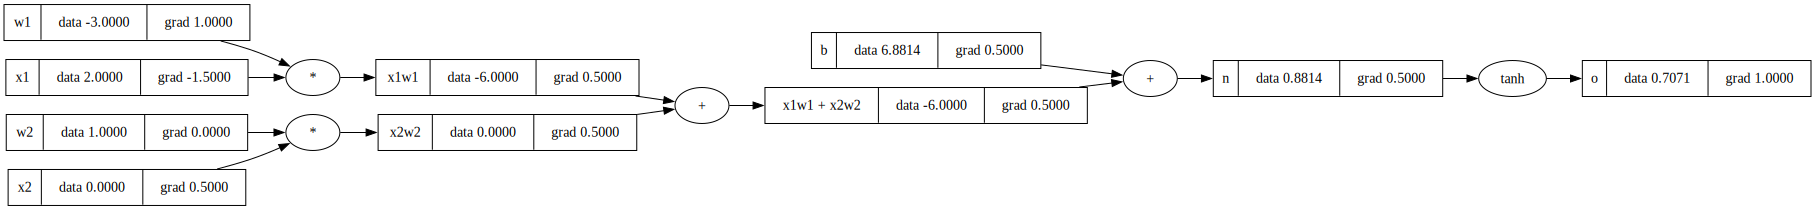

In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n  = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

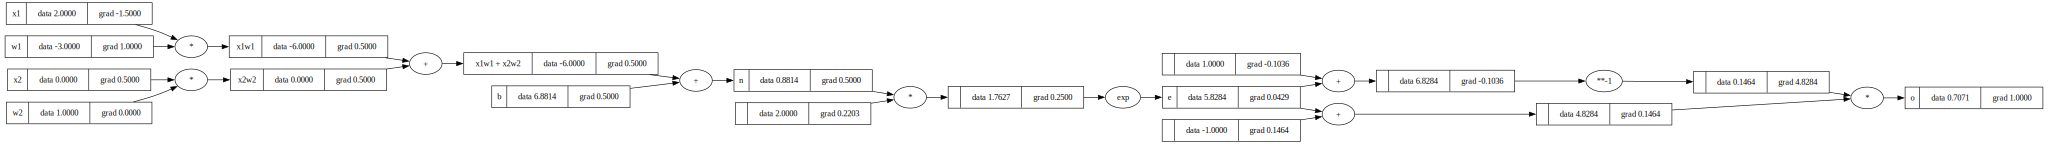

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n  = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp() ; e.label = 'e'
o = (e - 1) / (e + 1)
#---
o.label = 'o'

o.backward()
draw_dot(o)

In [7]:
import torch

x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad  = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print("out", o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


out 0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [8]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def  __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

n = MLP(3, [4,4,1])

In [10]:
iters = 10000
lr = 0.05
def train():
    for k in range(1,iters+1):
        
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum([(yout - y_ground_truth)**2 for y_ground_truth, yout in zip(ys, ypred)])
        
        # zero grad
        for p in n.parameters():
            p.grad = 0.0
        
        # back pass
        loss.backward()
        
        # update vals via sgd
        for p in n.parameters():
            p.data += -lr * p.grad
        
        print(f"Iteration:{k} : Loss:{loss.data:.8f}\n" if k%1000==0 else '', end='')
    print(ypred)

In [11]:
train()

Iteration:1000 : Loss:0.00066337
Iteration:2000 : Loss:0.00032519
Iteration:3000 : Loss:0.00021489
Iteration:4000 : Loss:0.00016031
Iteration:5000 : Loss:0.00012778
Iteration:6000 : Loss:0.00010620
Iteration:7000 : Loss:0.00009083
Iteration:8000 : Loss:0.00007934
Iteration:9000 : Loss:0.00007042
Iteration:10000 : Loss:0.00006330
[Value(data=0.9969072879013567), Value(data=-0.9978529314320758), Value(data=-0.9946552589843551), Value(data=0.9954655220286679)]
